# Train Stats

```
 ----------------------------------------------------------------------------------------
/                                                                                        \
| /$$$$$$$$                 /$$            /$$$$$$   /$$                 /$$             |
||__  $$__/                |__/           /$$__  $$ | $$                | $$             |
|   | $$  /$$$$$$  /$$$$$$  /$$ /$$$$$$$ | $$  \__//$$$$$$    /$$$$$$  /$$$$$$   /$$$$$$$|
|   | $$ /$$__  $$|____  $$| $$| $$__  $$|  $$$$$$|_  $$_/   |____  $$|_  $$_/  /$$_____/|
|   | $$| $$  \__/ /$$$$$$$| $$| $$  \ $$ \____  $$ | $$      /$$$$$$$  | $$   |  $$$$$$ |
|   | $$| $$      /$$__  $$| $$| $$  | $$ /$$  \ $$ | $$ /$$ /$$__  $$  | $$ /$$\____  $$|
|   | $$| $$     |  $$$$$$$| $$| $$  | $$|  $$$$$$/ |  $$$$/|  $$$$$$$  |  $$$$//$$$$$$$/|
|   |__/|__/      \_______/|__/|__/  |__/ \______/   \___/   \_______/   \___/ |_______/ |
|                                                                                        |
|                                                                                        |
|                                                                                        |
|                                      🚂 ¯\_(ツ)_/¯?                                     |
\                                                                                        /
 ----------------------------------------------------------------------------------------
    \     
     \     
      \      
           ___ ____
         ⎛   ⎛ ,----
          \  //==--'
     _//|,.·//==--'    ____________________________
    _OO≣=-  ︶ ᴹw ⎞_§ ______  ___\ ___\ ,\__ \/ __ \
   (∞)_, )  (     |  ______/__  \/ /__ / /_/ / /_/ /
     ¨--¨|| |- (  / ______\____/ \___/ \__^_/  .__/
         ««_/  «_/ jgs/bd808                /_/
```

In which I look at data from the past several hundred trains and pretend that I know how to do exploratory data analysis.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

engine = create_engine('sqlite:///data/train.db')
df = pd.read_sql('''
SELECT
    version,
    rollbacks,
    rollbacks_time,
    patches,
    group0_delay_days,
    group1_delay_days,
    group2_delay_days,
    (group0_delay_days +
     group1_delay_days +
     group2_delay_days) as total_delay,
    total_time as train_total_time,
    comments,
    insertions,
    deletions,
    time_in_review,
    loc,
    patch_deps,
    link,
    (select count(*) from file f where f.patch_id = p.id) as file_count
FROM train t
JOIN patch p ON p.train_id = t.id
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')

# 🧐 Preliminary thinking

thinking....

Looking at the dataset desribed below it mostly looks correct. I note that the max of the `group[N]_delay_days` is `6` for every day and I'm doing some `N % 7` math somewhere on `.isoweekday()` so that's probably under-reporting. Overall the data looks ok. 👌

# 📑 Aggregation

There is 1×`csv`/train and each row is a patch that went out with that train. Information that is true for an **entire train** (like the _number of patches_, the _number of rollbacks_, the _train conductor_, etc) is **repeated** for every row. The data in the `csv` files is not normalized. It's like a "left join".

We need to aggregate differently per column. Some columns should be the `max`, others should be `sum`med.

In [4]:
# from scipy import stats
import numpy

def count_outliers(x):
    return len(x[x > df[x.name].quantile(0.95)])

agg_df = df.groupby('version').agg({
#    'conductor': lambda x:stats.mode(x)[0],  # I don't know that I care about this…keeping it here to save me from looking at StackOverflow®™©
    'rollbacks': 'max',
    'comments': 'sum',
    'insertions': 'sum',
    'deletions': 'sum',
    'loc': ['sum', count_outliers],
    'patches': 'sum',
    'time_in_review': ['sum', count_outliers],
    'patches': ['max', count_outliers],
    'rollbacks_time': 'max',
    'total_delay': 'max',
    'train_total_time': 'max',
    'file_count': ['sum', count_outliers],
    'patch_deps': ['sum', count_outliers],
})
agg_df.head()

rollbacks comments insertions deletions     loc                 \
                    max      sum        sum       sum     sum count_outliers   
version                                                                        
1.31.0-wmf.1          0     1416       6364      4758   11122              2   
1.31.0-wmf.11         1     1799      77419     68374  145793              8   
1.31.0-wmf.12         0     1307       8200      4387   12587              4   
1.31.0-wmf.15         0     3887      42063     31584   73647             23   
1.31.0-wmf.16         1     1708      13006      8376   21382              4   

              patches                time_in_review                 \
                  max count_outliers            sum count_outliers   
version                                                              
1.31.0-wmf.1      399              0      243846663             14   
1.31.0-wmf.11     335              0      222575732              8   
1.31.0-wmf.12     374              0      102222853              5   
1.31.0-wmf.15     756              0      554129449             21   
1.31.0-wmf.16     288              0      184008614             16   

              rollbacks_time total_delay train_total_time file_count  \
                         max         max              max        sum   
version                                                                
1.31.0-wmf.1               0           0           180742       1072   
1.31.0-wmf.11           5833           0           173546       1109   
1.31.0-wmf.12              0           0           187456        797   
1.31.0-wmf.15              0           0           188190       2668   
1.31.0-wmf.16         431612          12           562921       1999   

                             patch_deps                 
              count_outliers        sum count_outliers  
version                                                 
1.31.0-wmf.1              13        128              2  
1.31.0-wmf.11             15        425             37  
1.31.0-wmf.12              6        160              9  
1.31.0-wmf.15             30        469             29  
1.31.0-wmf.16             22        150              8

## I _think_ ☝️ looks 🌠

…carrying on then.

Below is the correlation between all the numeric data in our set.

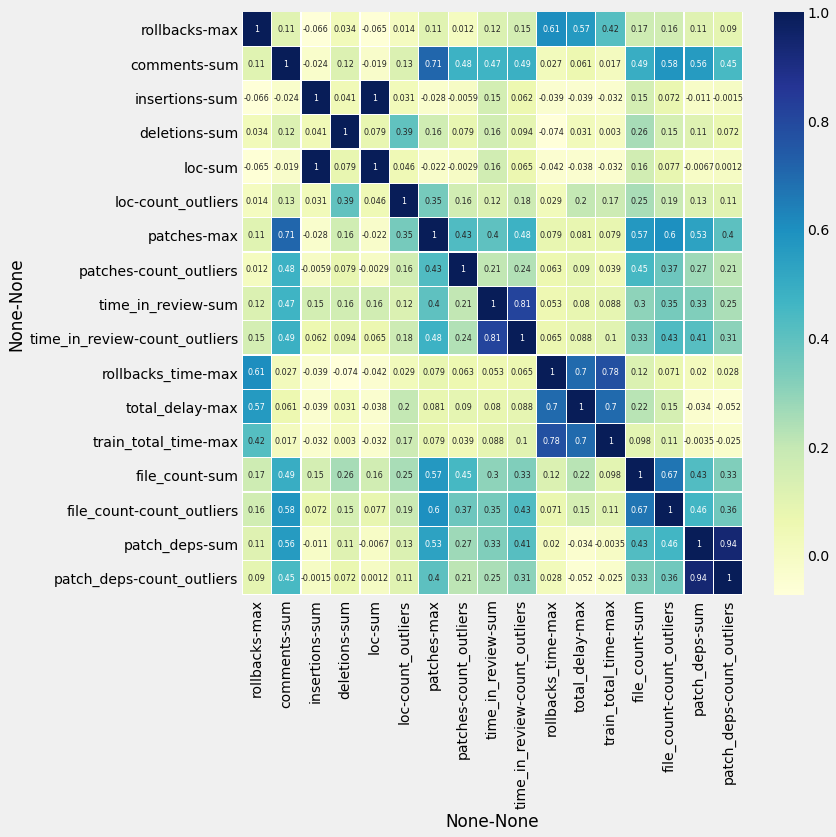

In [5]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(agg_df.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [7]:
from IPython.display import display

patch_df = pd.read_sql('''
    select
        t.version,
        filename,
        count(f.filename) as filename_count
    from file f
    join patch p on f.patch_id = p.id
    join train t on t.id = p.train_id
    group by filename, t.version
    order by filename_count desc;''', engine)
display(patch_df[patch_df['version'] == '1.37.0-wmf.3'])

,version,filename,filename_count
174,1.37.0-wmf.3,extension.json,35
302,1.37.0-wmf.3,repo/includes/WikibaseRepo.php,23
469,1.37.0-wmf.3,RELEASE-NOTES-1.37,15
590,1.37.0-wmf.3,composer.json,13
666,1.37.0-wmf.3,i18n/en.json,12
...,...,...,...
197036,1.37.0-wmf.3,wikimedia/remex-html/RemexHtml/DOM/DOMBuilder.php,1
197045,1.37.0-wmf.3,wikimedia/remex-html/RemexHtml/GenerateDataFil...,1
197402,1.37.0-wmf.3,wikimedia/zest-css/CHANGELOG.md,1
197410,1.37.0-wmf.3,wikimedia/zest-css/src/Zest.php,1
